In [250]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc

import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import scipy as sp
from scipy.sparse import linalg

First we import the data from the test simulations

In [159]:
simDataTable=pd.read_csv("Test_Simulation_Milestoning_Data.csv")
simDataTable.head()

,Window,Frame,Time,X,V,F,E
0,0,499,0.499,-4.194121,0.169740,0.131066,0.582288
1,0,999,0.999,-4.275652,-0.031547,0.390135,0.575607
2,0,1499,1.499,-4.167321,-0.190520,0.130229,0.583354
3,0,1999,1.999,-3.959980,-0.298505,0.123749,0.590011
4,0,2499,2.499,-3.670802,-0.304773,-0.677272,0.558500


Now we need to bin the coordinate data.
For this we need to know the window bounds

In [160]:
windowWidth=.5
windowK=10.0
windowCenters=np.arange(-8,9)*windowWidth
winMaxs=windowCenters+windowWidth/2.0
winMins=windowCenters-windowWidth/2.0

For the one dimensional case, assingin bin indices can be easily accomplished by the numpy command 'digitize'

The example below illustartes this.

Note that we need two additional 'bins'.
Bin zero will account for anything to the left of the leftmost window edge and the last bin will capture anything to the right of the rightmost window edge.

We then use didgitize to apply this bin indexing to an array of numbers from -5 to 5 spaced .25 units apart.

In [161]:
xvals=np.arange(-20,21)*.25
print zip(np.arange(len(windowCenters))+1,zip(winMins,winMaxs))
print zip(xvals,np.digitize(xvals,bins=np.concatenate([winMins,[winMaxs[-1]]])))

[(1, (-4.25, -3.75)), (2, (-3.75, -3.25)), (3, (-3.25, -2.75)), (4, (-2.75, -2.25)), (5, (-2.25, -1.75)), (6, (-1.75, -1.25)), (7, (-1.25, -0.75)), (8, (-0.75, -0.25)), (9, (-0.25, 0.25)), (10, (0.25, 0.75)), (11, (0.75, 1.25)), (12, (1.25, 1.75)), (13, (1.75, 2.25)), (14, (2.25, 2.75)), (15, (2.75, 3.25)), (16, (3.25, 3.75)), (17, (3.75, 4.25))]
[(-5.0, 0), (-4.75, 0), (-4.5, 0), (-4.25, 1), (-4.0, 1), (-3.75, 2), (-3.5, 2), (-3.25, 3), (-3.0, 3), (-2.75, 4), (-2.5, 4), (-2.25, 5), (-2.0, 5), (-1.75, 6), (-1.5, 6), (-1.25, 7), (-1.0, 7), (-0.75, 8), (-0.5, 8), (-0.25, 9), (0.0, 9), (0.25, 10), (0.5, 10), (0.75, 11), (1.0, 11), (1.25, 12), (1.5, 12), (1.75, 13), (2.0, 13), (2.25, 14), (2.5, 14), (2.75, 15), (3.0, 15), (3.25, 16), (3.5, 16), (3.75, 17), (4.0, 17), (4.25, 18), (4.5, 18), (4.75, 18), (5.0, 18)]


We can now use the above procedure to bin our X coordinate data for each window.

We can make use of digitize as above. We note that if you give digitize N bin edges, it will give you N+1 bins. Also, by default it assumes the edges are the left hand sides of each bin.

This means:
    1. We want to give nWindows-1 bin edges
    2. We want to give it the window minima (left hand edges)

In [222]:
binEdges=winMins[1:] #np.concatenate([winMins,[winMaxs[-1]]])
digitize_kwds={"bins":binEdges}
simDataTable['X_Index']=simDataTable.X.apply(np.digitize,**digitize_kwds)
simDataTable.head()

,Window,Frame,Time,X,V,F,E,X_Index
0,0,499,0.499,-4.194121,0.169740,0.131066,0.582288,0
1,0,999,0.999,-4.275652,-0.031547,0.390135,0.575607,0
2,0,1499,1.499,-4.167321,-0.190520,0.130229,0.583354,0
3,0,1999,1.999,-3.959980,-0.298505,0.123749,0.590011,0
4,0,2499,2.499,-3.670802,-0.304773,-0.677272,0.558500,1


Before proceeding, it is a good idea to visualize the results.

We can make use of a hand python widget to allow us to easily select a given window to view.

The red line shows the actual observed values of $x$

The orange dots indicate the window bin that x was assigned into for the given frame.

The black horizontal lines indicate the edges of the window bin.

An intersting note is that there are no transitions on the negative side of window 0 and no
positive side of window 16. This essentially means that we count anything to the right of bin 16's right edge as part of bin 16 and anything to the left of bin 0's left edge as part of bin0

In [228]:
@interact
def plot_window(window=(simDataTable.Window.min(),simDataTable.Window.max(),1)):
    plt.figure(figsize=(12,9))
    plt.rcParams['axes.facecolor']='grey'
    nWindows=len(simDataTable.Window.unique())
    plotData=simDataTable[simDataTable.Window==window]
    plt.scatter(plotData.Time,
                (plotData.X_Index-(nWindows-1)/2.)*windowWidth,
                c='orange',#Spectral11[window%11],
                s=4,
                label='Window_%02g'%window)
    plt.plot(plotData.Time,
             plotData.X,
             'r',
             #Spectral11[window%11],
             label='Window_%02g'%window)
    plt.plot(plotData.Time,
             [winMins[window]]*len(plotData),c='k')
    plt.plot(plotData.Time,
             [winMaxs[window]]*len(plotData),c='k')
    plt.legend()
    plt.grid()
    plt.show()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT04LCBkZXNjcmlwdGlvbj11J3dpbmRvdycsIG1heD0xNiksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC1pbnTigKY=


We are now ready to compute the escape matrix.

This is an Nwindow by Nwindow matrix with a diagonal of 0.
The off diagonals represent the probability of transitioning form one window to another.

I.e.
$$M_{i,j}=N_{i->j}/N_{i}$$
where $M_{i,j}$ is an element of the escape matrix, $N_{i->j}$ is the number of frames where $x$ is observed in bin $j$ when it was in bin $i$ on the previous frame, and $N_{i}$ is the number of frames where $x$ is observed in bin $i$ as computed from the simulation with the milestoning well for bin $i$

--- --- ---
escapeMatrix entry for window 0:
[0.000, 0.177, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.823
--- --- ---
escapeMatrix entry for window 1:
[0.201, 0.000, 0.194, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 0.000
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.604
--- --- ---
escapeMatrix entry for window 2:
[0.000, 0.188, 0.000, 0.180, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 1.038
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.632
--- --- ---
escapeMatrix entry for window 3:
[0.000, 0.000, 0.177, 0.000, 0.177, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 1.042
Probabi

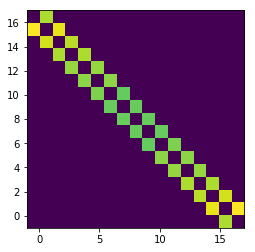

In [269]:
#note that our window indexing starts at 0
#this causes a problem for boolean operations since 0 evaluates to false
#while non-zero evaluates as true.
#moreover, our 'bins' span from -1 to nWindows+1...
#thus we will temporarily add 2 to all window and X_index values
#this way our X_index will span values from 1 to nWindows+2
windows=np.sort(simDataTable.Window.unique())
xbins=np.sort(simDataTable.X_Index.unique())
nBins=len(xbins)
escapeMat=np.zeros((nBins,nBins))
pCenters=np.zeros(len(windows))
escapeRatios=np.zeros(len(windows))
#iVal->escape matrix row index
#xbin->window
#cVal->place holder for bin index with indexing starting at 1
for iVal,xbin in enumerate(xbins):
    if xbin in windows:
        tempDat=simDataTable[simDataTable.Window==xbin]
        cVal=xbin+1
        binVec=np.array(tempDat.X_Index+1)
        binC=(binVec==cVal)
        binT=(1-binC[1:])*binC[:-1]*binVec[1:]
        tCounts=np.unique(binT,return_counts=True)
        transInds=tCounts[0][1:] #first entry should always be for binT==0
        transCounts=tCounts[1][1:]
        cCount=np.sum(binC)
        for iInd,Ind in enumerate(transInds):
            escapeMat[iVal,Ind-1]=1.*transCounts[iInd]/cCount
        print "--- --- ---"
        print "escapeMatrix entry for window %g:"%xbin
        print '['+', '.join(map(lambda x: '%.3f'%x,escapeMat[iVal,:]))+']'
        if (iVal > 0) & (iVal < (len(windows)-1)):
            escapeRatios[iVal]=1.*escapeMat[iVal,iVal-1]/escapeMat[iVal,iVal+1]
            print 'Ratio of left to right exit frequencies: %.3f'%(
                escapeRatios[iVal-1])
        pCenters[iVal]=1.0-np.sum(escapeMat[iVal,:])
        print "Probability of being inside window (1-M(i,i)+1-M(i,i-1)): %.3f"%(
            pCenters[iVal])
print "--- --- ---"

plt.imshow(escapeMat,extent=(-1,nBins,-1,nBins))
plt.show()

[]

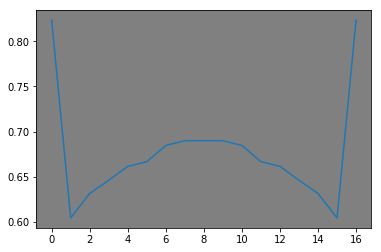

In [270]:
plt.plot(pCenters)
plt.plot()

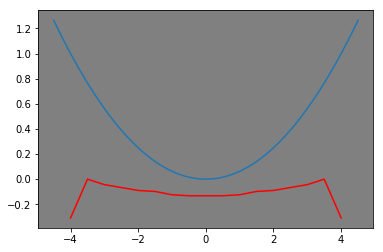

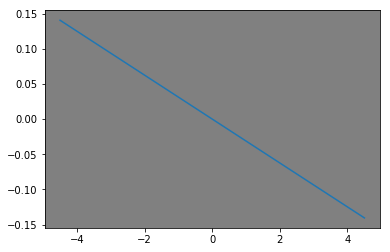

In [271]:
xVals=np.linspace(-4.5,4.5,100)
potFun=lambda x: (x/4.0)**2

potDer=lambda x: -x/(2*4.0**2)

yVals=potFun(xVals)

plt.plot(xVals,yVals)
plt.plot(windowCenters,-np.log(pCenters)+np.log(np.min(pCenters)),'r')
plt.show()

plt.plot(xVals,potDer(xVals))
plt.show()

We now need to use the escape matrix to set up and solve a system of linear equations to find the equilibrium probability of being in each cell.

From "Maragliano, L. et. al. <I>J. Chem. Theory Comput.</I> 2009, 5; DOI:10.1021/ct900279z" we have:

\begin{equation*}
    \sum\limits_{\gamma=1,\gamma\neq\alpha}^{K}\pi_\gamma\nu_{\gamma\alpha}=
    \sum\limits_{\gamma=1,\gamma\neq\alpha}^{K}\pi_\alpha\nu_{\alpha\gamma}; 
    \label{eq:eq_flux_equation} \tag{1}
\end{equation*}

\begin{equation*}
  \sum\limits_{\alpha=1}^{K}\pi_\alpha=1
  \label{eq:eq_probability_equation} \tag{2}
\end{equation*}
  
where $\nu_{\alpha\gamma}$ is the transition frequency (escape matrix entry) for moving from cell $\alpha$ to cell (window) $\gamma$ when starting from cell $\alpha$, $K$ is the total number of cells, and $\pi_\alpha$ is the equilibrium probability (which we are trying to calculate) for cell $\alpha$

To make this a little more ammenable for numerical solution here, we will recast this in a matrix vector form.

Let $\matrix{R}$ be the escape matrix such that $R_{i,i}=0$ and $R_{i,j}$ is corresponding element of our escape matrix. Thus $R_{i,j}=\nu_{\alpha\gamma}$ for $\alpha=i$ and $\gamma=j$.

Next, let $\overline{\pi}$ be the vector of equilibrium probabilities being computed.

We may then write the left hand side of equation (\ref{eq:eq_flux_equation}) as $\matrix{R}\overline{\pi}$

For the right hand side of equation (\ref{eq:eq_flux_equation}) we first define a diagonal matrix $\matrix{D}$ with entries $D_{i,i}$ equal to the row sums of matrix $\matrix{R}$.

E.g. $D_{i,i}=\sum\limits_{j}R_{i,j}$

We may then recast the right hand side of (\ref{eq:eq_flux_equation}) as $\matrix{D}\overline{\pi}$

Putting this together equation (\ref{eq:eq_flux_equation}) becomes:

\begin{equation*}
    \matrix{R}\overline{\pi}=\matrix{D}\overline{\pi}
    \label{eq:eq_flux_matVec} \tag{3}
\end{equation*}

we may then write:
\begin{equation*}
    \left(\matrix{R}-\matrix{D}\right)\overline{\pi}=0
    \label{eq:eq_flux_a} \tag{3a}
\end{equation*}

In [272]:
Rmat=np.matrix(escapeMat)
Dmat=np.matrix(np.diag(np.sum(escapeMat,axis=0)))
Pvec=pCenters #use this as a starting guess
Pvec=Pvec/np.sum(Pvec)

RDmat=Rmat-Dmat

[0.07154168 0.05253508 0.05489046 0.05615716 0.05749423 0.05793992
 0.05949985 0.05996108 0.05996108 0.05996108 0.05949985 0.05793992
 0.05749423 0.05615716 0.05489046 0.05253508 0.07154168]
[0.05640297 0.06428007 0.06228692 0.06109138 0.05843434 0.05753333
 0.05573656 0.05615571 0.05615742 0.05615571 0.05573656 0.05753333
 0.05843434 0.06109138 0.06228692 0.06428007 0.05640297]


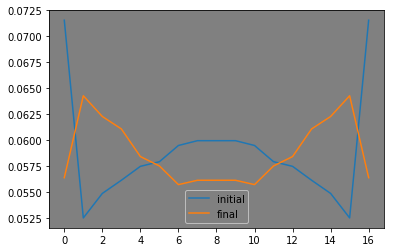

In [273]:
print Pvec
plt.plot(Pvec,label='initial')
Pvec=linalg.cg(RDmat,np.zeros(len(Pvec)),x0=Pvec)[0]
print Pvec
np.sum(Pvec)
plt.plot(Pvec,label='final')
plt.legend()
plt.show()

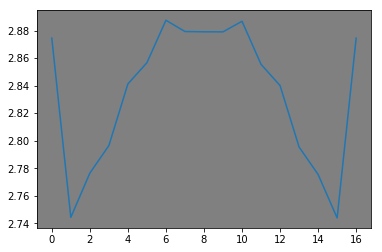

In [259]:
plt.plot(-np.log(Pvec))
plt.show()